In [1]:
import pandas as pd
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress TensorFlow warnings

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# --- 1. Load Data ---
print("Downloading dataset...")
path = kagglehub.dataset_download("dhivyeshrk/diseases-and-symptoms-dataset")
file_path = os.path.join(path, "Final_Augmented_dataset_Diseases_and_Symptoms.csv")
df = pd.read_csv(file_path)

print("Dataset loaded successfully.")

Using Colab cache for faster access to the 'diseases-and-symptoms-dataset' dataset.
Dataset loaded successfully.


In [2]:
# --- 2. Preprocessing ---
print("\nPreprocessing data...")

# Encode target (disease labels)
le = LabelEncoder()
df['disease_encoded'] = le.fit_transform(df['diseases'])

# Define Features (X) and target (y)
X = df.drop(columns=['diseases', 'disease_encoded'])
y = df['disease_encoded']

# Remove diseases with only 1 sample
disease_counts = df['disease_encoded'].value_counts()
single_sample_diseases = disease_counts[disease_counts == 1].index
df_filtered = df[~df['disease_encoded'].isin(single_sample_diseases)]

X = df_filtered.drop(columns=['diseases', 'disease_encoded'])
y = df_filtered['disease_encoded']

# Re-fit the LabelEncoder on the filtered data
le = LabelEncoder()
y = le.fit_transform(df_filtered['diseases'])
num_classes = len(le.classes_)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Preprocessing data...
Train size: (197540, 377), Test size: (49386, 377)


In [3]:
# --- 3. Train Traditional Models ---
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=300, random_state=42)
}

# Dictionary to store results
accuracies = {}
all_predictions = {}

print("\nTraining traditional models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    all_predictions[name] = y_pred
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Training traditional models...
Decision Tree Accuracy: 0.8162
Naive Bayes Accuracy: 0.8667
Logistic Regression Accuracy: 0.8671


In [6]:
# --- 4. Train Deep Learning Model ---
print("\nPreparing data for Deep Learning model...")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Build DNN Model
model_dl = Sequential()
model_dl.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(64, activation='relu'))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(num_classes, activation='softmax'))

model_dl.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Train DNN Model (10 epochs is sufficient based on your log)
print("\nTraining Deep Learning model...")
history = model_dl.fit(
    X_train_scaled,
    y_train_encoded,
    epochs=28,
    batch_size=64,
    validation_data=(X_test_scaled, y_test_encoded),
    verbose=1
)

# Evaluate and store DNN results
loss, accuracy = model_dl.evaluate(X_test_scaled, y_test_encoded, verbose=0)
accuracies["Deep Learning (DNN)"] = accuracy
y_pred_dl_probs = model_dl.predict(X_test_scaled)
y_pred_dl = np.argmax(y_pred_dl_probs, axis=1)
all_predictions["Deep Learning (DNN)"] = y_pred_dl
print(f"\nDeep Learning Model Test Accuracy: {accuracy:.4f}")


Preparing data for Deep Learning model...

Training Deep Learning model...
Epoch 1/28
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.3961 - loss: 2.9882 - val_accuracy: 0.8227 - val_loss: 0.5399
Epoch 2/28
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.7584 - loss: 0.7842 - val_accuracy: 0.8426 - val_loss: 0.4414
Epoch 3/28
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.7887 - loss: 0.6547 - val_accuracy: 0.8511 - val_loss: 0.4030
Epoch 4/28
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.8002 - loss: 0.6021 - val_accuracy: 0.8542 - val_loss: 0.3915
Epoch 5/28
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8069 - loss: 0.5703 - val_accuracy: 0.8518 - val_loss: 0.3833
Epoch 6/28
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.8104 - loss: 0.5570 - val_accuracy: 0.8536 - val_loss: 0.3750
Epoch 7/28
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8171 - loss: 0.5301 - val_accuracy: 0.8565 - val_loss: 0.3667
Epoch 

In [7]:
# --- 5. Build and Evaluate Ensemble Model ---
print("\nBuilding ensemble model...")

# Create a DataFrame of all predictions
predictions_df = pd.DataFrame(all_predictions)

# Use .mode() to find the most frequent prediction (majority vote)
ensemble_pred = predictions_df.mode(axis=1)[0].astype(int)
all_predictions["Ensemble (Voting)"] = ensemble_pred

# Evaluate the ensemble
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
accuracies["Ensemble (Voting)"] = ensemble_accuracy
print(f"Ensemble Model (Majority Vote) Accuracy: {ensemble_accuracy:.4f}")


Building ensemble model...
Ensemble Model (Majority Vote) Accuracy: 0.8625



--- Graph: Ensemble Prediction Confidence Distribution ---


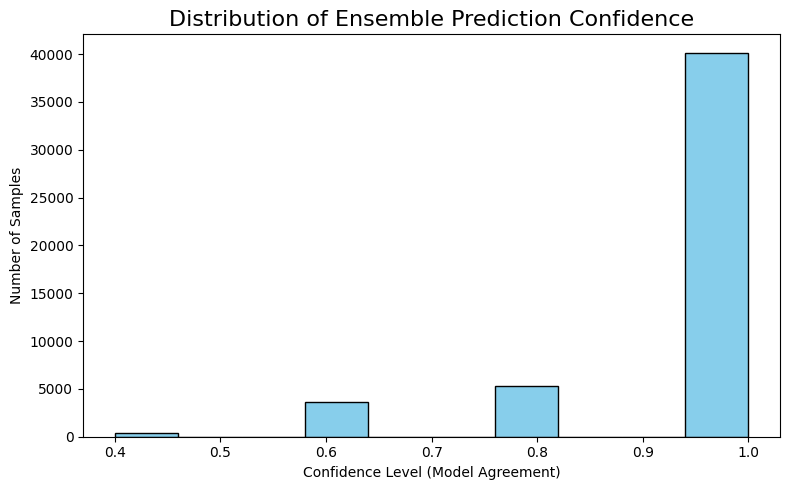

In [16]:
# --- Graph: Prediction Confidence Distribution (Ensemble) ---
print("\n--- Graph: Ensemble Prediction Confidence Distribution ---")

# Step 1: Create ensemble probabilities (soft voting) if not already done
# If you only have hard-voting predictions, you can simulate probabilities
predictions_df = pd.DataFrame(all_predictions)

# Convert to a numerical mode (most frequent label)
ensemble_pred = predictions_df.mode(axis=1)[0].astype(int)

# Approximate confidence = proportion of models that agreed
model_count = len(predictions_df.columns)
confidence_scores = []
for i in range(len(predictions_df)):
    # Count how many models agreed on the ensemble prediction
    same_votes = (predictions_df.iloc[i] == ensemble_pred[i]).sum()
    confidence = same_votes / model_count
    confidence_scores.append(confidence)

# Step 2: Plot distribution
plt.figure(figsize=(8, 5))
plt.hist(confidence_scores, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Ensemble Prediction Confidence', fontsize=16)
plt.xlabel('Confidence Level (Model Agreement)')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()


--- Graph 1: Model Accuracy Comparison ---


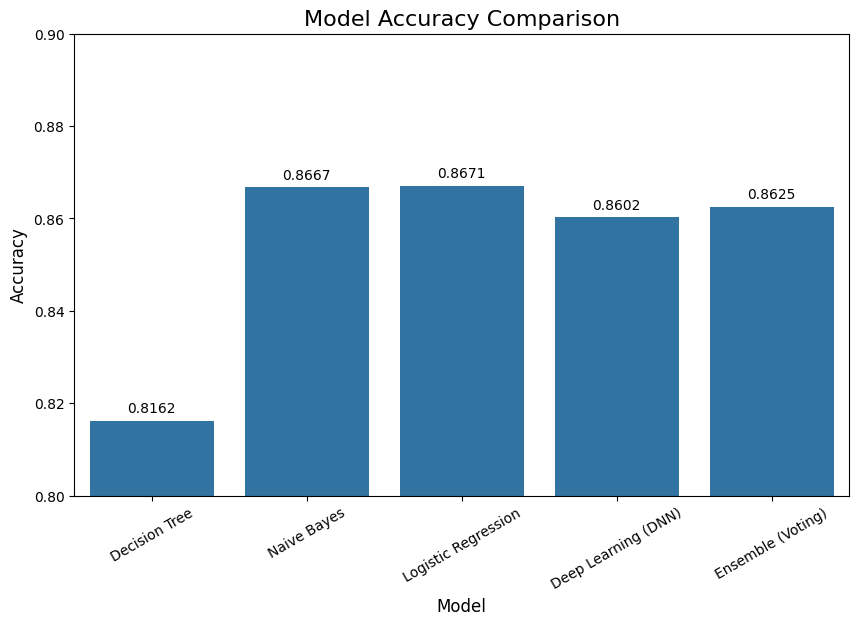

In [8]:
print("\n--- Graph 1: Model Accuracy Comparison ---")
acc_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])

plt.figure(figsize=(10, 6))
splot = sns.barplot(x='Model', y='Accuracy', data=acc_df)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=30)
plt.ylim(0.8, 0.9) # Zoom in on the top performers

# Add text labels
for p in splot.patches:
    splot.annotate(f"{p.get_height():.4f}",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')
plt.show()


--- Graph 2: Deep Learning Training History ---


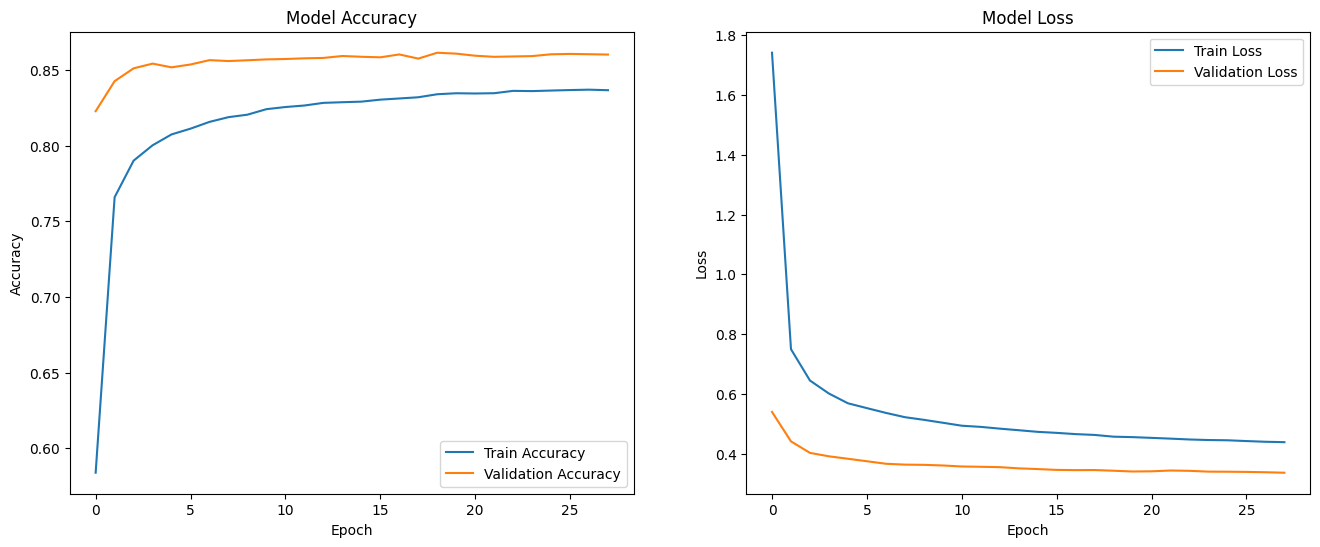

In [9]:
print("\n--- Graph 2: Deep Learning Training History ---")
history_df = pd.DataFrame(history.history)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Accuracy
ax1.plot(history_df['accuracy'], label='Train Accuracy')
ax1.plot(history_df['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot Loss
ax2.plot(history_df['loss'], label='Train Loss')
ax2.plot(history_df['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()


--- Graph 3: Detailed Metrics Comparison (Weighted Avg) ---


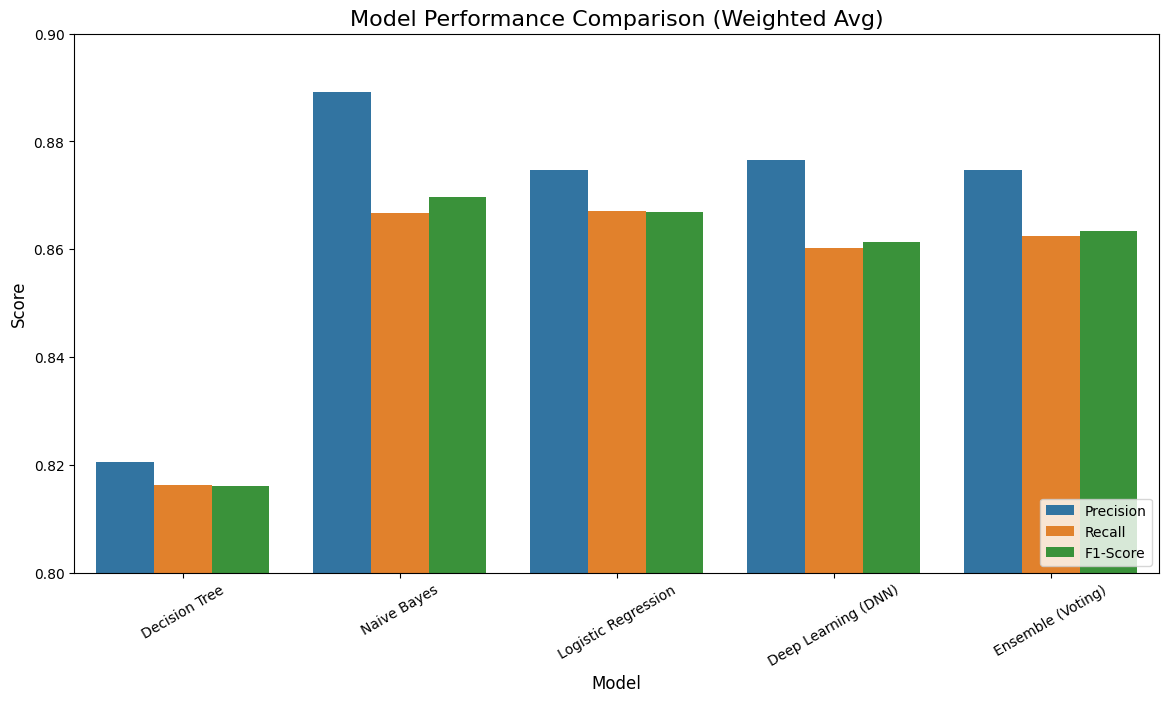

In [10]:
print("\n--- Graph 3: Detailed Metrics Comparison (Weighted Avg) ---")
metrics_data = []

for name, preds in all_predictions.items():
    # Note: 'average='weighted'' accounts for class imbalance.
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted')
    metrics_data.append({"Model": name, "Metric": "Precision", "Score": precision})
    metrics_data.append({"Model": name, "Metric": "Recall", "Score": recall})
    metrics_data.append({"Model": name, "Metric": "F1-Score", "Score": f1})

metrics_df = pd.DataFrame(metrics_data)

plt.figure(figsize=(14, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df)
plt.title('Model Performance Comparison (Weighted Avg)', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=30)
plt.ylim(0.8, 0.9)
plt.legend(loc='lower right')
plt.show()


--- Graph 4: Confusion Matrix Comparison (Top 10 Diseases) ---


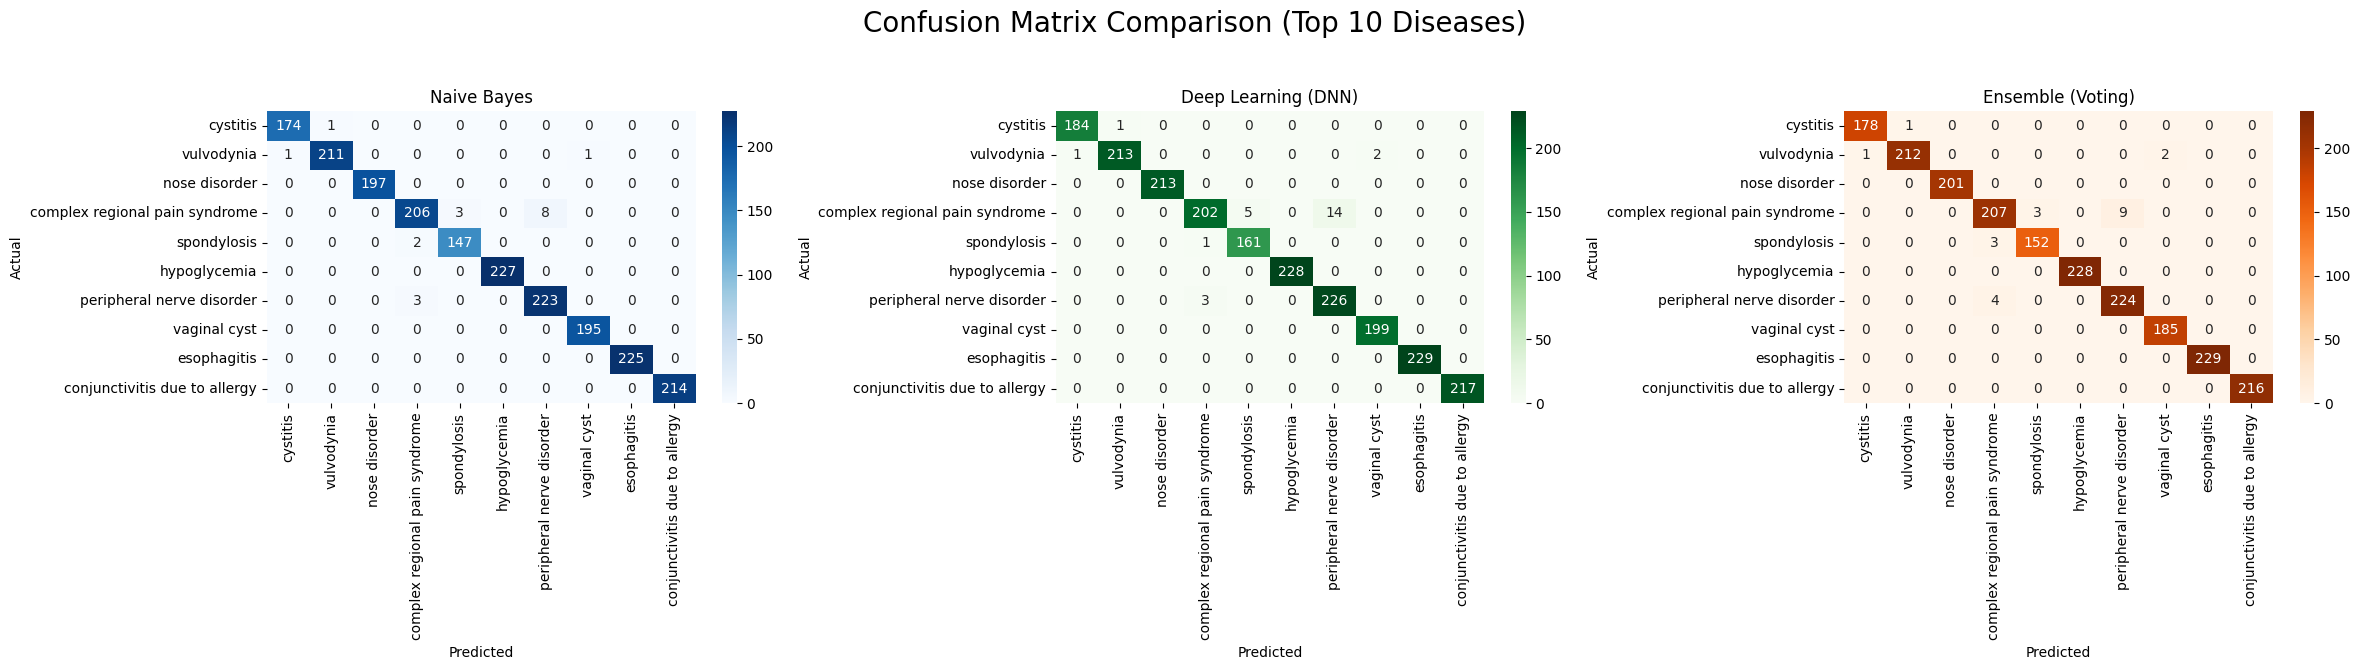

In [11]:
print("\n--- Graph 4: Confusion Matrix Comparison (Top 10 Diseases) ---")
# Convert y to pandas Series to use value_counts()
top10_diseases = pd.Series(y).value_counts().head(10).index
top10_names = le.inverse_transform(top10_diseases)
mask = np.isin(y_test, top10_diseases)

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Confusion Matrix Comparison (Top 10 Diseases)', fontsize=20)

# Model 1: Naive Bayes
cm_nb = confusion_matrix(y_test[mask], all_predictions["Naive Bayes"][mask], labels=top10_diseases)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues",
            xticklabels=top10_names, yticklabels=top10_names,
            ax=axes[0])
axes[0].set_title("Naive Bayes")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Model 2: Deep Learning (DNN)
cm_dl = confusion_matrix(y_test[mask], all_predictions["Deep Learning (DNN)"][mask], labels=top10_diseases)
sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Greens",
            xticklabels=top10_names, yticklabels=top10_names,
            ax=axes[1])
axes[1].set_title("Deep Learning (DNN)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Model 3: Ensemble
cm_ensemble = confusion_matrix(y_test[mask], all_predictions["Ensemble (Voting)"][mask], labels=top10_diseases)
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Oranges",
            xticklabels=top10_names, yticklabels=top10_names,
            ax=axes[2])
axes[2].set_title("Ensemble (Voting)")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
# --- 7. Save Models for Web App ---
print("\nSaving all models and preprocessors for web application...")
model_dir = "trained_models"
os.makedirs(model_dir, exist_ok=True)

# 1. Save traditional models
for name, model in models.items():
    filename = os.path.join(model_dir, f"{name.replace(' ', '_').lower()}_model.pkl")
    joblib.dump(model, filename)
    print(f"Saved {name} model.")

# 2. Save the Deep Learning model
dl_filename = os.path.join(model_dir, "deep_learning_model.h5")
model_dl.save(dl_filename)
print("Saved Deep Learning model.")

# 3. Save the Preprocessors (CRITICAL for a web app)
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))
print("Saved MinMaxScaler.")
joblib.dump(le, os.path.join(model_dir, "label_encoder.pkl"))
print("Saved Label Encoder.")

# 4. Save the feature list (for the SBERT function)
joblib.dump(list(X.columns), os.path.join(model_dir, "symptom_columns.pkl"))
print("Saved symptom columns list.")

# 5. Save the final Naive Bayes model (trained on all data) for the SBERT app
final_model_nb = GaussianNB()
final_model_nb.fit(X, y) # Train on full data
joblib.dump(final_model_nb, os.path.join(model_dir, "final_nb_model_for_sbert.pkl"))
print("Saved final Naive Bayes model (for SBERT app).")

print(f"\nAll models and components saved to the '{model_dir}' directory.")


Saving all models and preprocessors for web application...


Saved Decision Tree model.
Saved Naive Bayes model.
Saved Logistic Regression model.
Saved Deep Learning model.
Saved MinMaxScaler.
Saved Label Encoder.
Saved symptom columns list.
Saved final Naive Bayes model (for SBERT app).

All models and components saved to the 'trained_models' directory.


In [13]:
import pandas as pd
import numpy as np
import os
import joblib
from tensorflow.keras.models import load_model
from sentence_transformers import SentenceTransformer, util
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# --- 1. Define Model Directory ---
MODEL_DIR = "trained_models"

# --- 2. Load All Components ---
print("Loading all models and preprocessors...")
models = {
    "decision_tree": joblib.load(os.path.join(MODEL_DIR, "decision_tree_model.pkl")),
    "naive_bayes": joblib.load(os.path.join(MODEL_DIR, "naive_bayes_model.pkl")),
    "logistic_regression": joblib.load(os.path.join(MODEL_DIR, "logistic_regression_model.pkl"))
}
model_dl = load_model(os.path.join(MODEL_DIR, "deep_learning_model.h5"))
scaler = joblib.load(os.path.join(MODEL_DIR, "scaler.pkl"))
le = joblib.load(os.path.join(MODEL_DIR, "label_encoder.pkl"))
symptoms = joblib.load(os.path.join(MODEL_DIR, "symptom_columns.pkl"))
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
symptom_embeddings = sbert_model.encode(symptoms, convert_to_tensor=True)
print("All models loaded successfully.")


# --- 3. The Final "Soft Voting" Prediction Function ---
def predict_disease_with_probabilities(patient_text: str, top_n: int = 3, similarity_threshold=0.4) -> dict:
    """
    Predicts the top N diseases from free-text using SBERT
    and averaging the probabilities of all 4 models.
    """

    # 1. CONVERT TEXT TO VECTOR using SBERT
    input_embedding = sbert_model.encode(patient_text, convert_to_tensor=True)
    cos_scores = util.cos_sim(input_embedding, symptom_embeddings)[0].cpu().numpy()

    input_vector = np.zeros(len(symptoms))
    matched_indices = np.where(cos_scores >= similarity_threshold)[0]

    if len(matched_indices) == 0:
        matched_indices = [np.argmax(cos_scores)]

    for idx in matched_indices:
        input_vector[idx] = 1

    # 2. PREPARE INPUTS
    input_df = pd.DataFrame([input_vector], columns=symptoms)
    input_scaled = scaler.transform(input_df)

    # 3. GET PROBABILITIES FROM ALL 4 MODELS
    # .predict_proba() returns shape (1, num_classes)
    prob_dt = models["decision_tree"].predict_proba(input_df)[0]
    prob_nb = models["naive_bayes"].predict_proba(input_df)[0]
    prob_lr = models["logistic_regression"].predict_proba(input_df)[0]
    prob_dl = model_dl.predict(input_scaled, verbose=0)[0]

    # 4. PERFORM ENSEMBLE (AVERAGE PROBABILITIES)
    # This is the "soft vote"
    avg_probs = (prob_dt + prob_nb + prob_lr + prob_dl) / 4.0

    # 5. GET TOP N PREDICTIONS
    # Get the indices of the top N probabilities
    top_n_indices = np.argsort(avg_probs)[-top_n:][::-1]

    # Get the disease names and their scores
    top_diseases = le.inverse_transform(top_n_indices)
    top_probabilities = avg_probs[top_n_indices]

    # 6. FORMAT AND RETURN
    # Create a dictionary of {disease: percentage}
    results = {disease: f"{prob*100:.2f}%" for disease, prob in zip(top_diseases, top_probabilities)}

    return results

# --- 4. Example Usage ---
print("\n--- Live Prediction Test with Probabilities ---")

# Example 1
input_1 = "I have a bad headache, I feel dizzy, and I'm nauseous"
diseases_1 = predict_disease_with_probabilities(input_1, top_n=3)
print(f"Input: '{input_1}'")
print("Predicted Diseases:")
for disease, prob in diseases_1.items():
    print(f"  - {disease}: {prob}")

# Example 2
input_2 = "My throat is sore and I have a high fever and body aches"
diseases_2 = predict_disease_with_probabilities(input_2, top_n=3)
print(f"\nInput: '{input_2}'")
print("Predicted Diseases:")
for disease, prob in diseases_2.items():
    print(f"  - {disease}: {prob}")

# Example 3
input_3 = "I am shivering, sweating, have high fever, and feel nauseous with body pain."
diseases_3 = predict_disease_with_probabilities(input_3, top_n=3)
print(f"\nInput: '{input_3}'")
print("Predicted Diseases:")
for disease, prob in diseases_3.items():
    print(f"  - {disease}: {prob}")

Loading all models and preprocessors...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

All models loaded successfully.

--- Live Prediction Test with Probabilities ---
Input: 'I have a bad headache, I feel dizzy, and I'm nauseous'
Predicted Diseases:
  - headache after lumbar puncture: 31.37%
  - stroke: 16.52%
  - hyperkalemia: 12.88%

Input: 'My throat is sore and I have a high fever and body aches'
Predicted Diseases:
  - tonsillitis: 99.73%
  - vocal cord polyp: 0.14%
  - scarlet fever: 0.03%

Input: 'I am shivering, sweating, have high fever, and feel nauseous with body pain.'
Predicted Diseases:
  - infectious gastroenteritis: 42.19%
  - hypovolemia: 26.23%
  - noninfectious gastroenteritis: 16.11%



--- Graph: SBERT Symptom Similarity Visualization ---


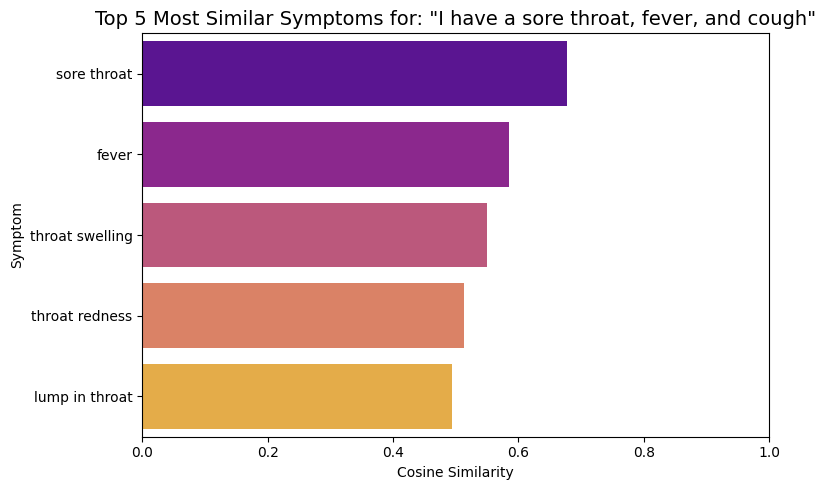

In [17]:
# --- Graph: SBERT Similarity Visualization ---
print("\n--- Graph: SBERT Symptom Similarity Visualization ---")

from sentence_transformers import SentenceTransformer, util

# Example input text
example_text = "I have a sore throat, fever, and cough"

# Get embeddings
input_embedding = sbert_model.encode(example_text, convert_to_tensor=True)
cos_scores = util.cos_sim(input_embedding, symptom_embeddings)[0].cpu().numpy()

# Get top 5 most similar symptoms
top_indices = np.argsort(cos_scores)[-5:][::-1]
top_symptoms = [symptoms[i] for i in top_indices]
top_scores = cos_scores[top_indices]

# Plot top 5 similarities
plt.figure(figsize=(8, 5))
sns.barplot(x=top_scores, y=top_symptoms, palette='plasma')
plt.title(f"Top 5 Most Similar Symptoms for: \"{example_text}\"", fontsize=14)
plt.xlabel("Cosine Similarity")
plt.ylabel("Symptom")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import numpy as np
import os
import joblib
from tensorflow.keras.models import load_model
from sentence_transformers import SentenceTransformer, util
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# --- 1. Define Model Directory ---
MODEL_DIR = "trained_models"

# --- 2. Load All Components ---
print("Loading all models and preprocessors...")
models = {
    "decision_tree": joblib.load(os.path.join(MODEL_DIR, "decision_tree_model.pkl")),
    "naive_bayes": joblib.load(os.path.join(MODEL_DIR, "naive_bayes_model.pkl")),
    "logistic_regression": joblib.load(os.path.join(MODEL_DIR, "logistic_regression_model.pkl"))
}
model_dl = load_model(os.path.join(MODEL_DIR, "deep_learning_model.h5"))
scaler = joblib.load(os.path.join(MODEL_DIR, "scaler.pkl"))
le = joblib.load(os.path.join(MODEL_DIR, "label_encoder.pkl"))
symptoms = joblib.load(os.path.join(MODEL_DIR, "symptom_columns.pkl"))

# Load SBERT model
print("Loading SBERT model (this may take a few seconds)...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
symptom_embeddings = sbert_model.encode(symptoms, convert_to_tensor=True)
print("All models and components loaded successfully!\n")

# --- 3. Prediction Function ---
def predict_disease_with_probabilities(patient_text: str, top_n: int = 3, similarity_threshold=0.4) -> dict:
    """Predicts top N diseases from free-text using SBERT + Soft Voting Ensemble."""

    # 1️⃣ Convert text to vector using SBERT
    input_embedding = sbert_model.encode(patient_text, convert_to_tensor=True)
    cos_scores = util.cos_sim(input_embedding, symptom_embeddings)[0].cpu().numpy()

    # 2️⃣ Create binary vector of symptoms
    input_vector = np.zeros(len(symptoms))
    matched_indices = np.where(cos_scores >= similarity_threshold)[0]

    if len(matched_indices) == 0:
        matched_indices = [np.argmax(cos_scores)]  # fallback if no matches

    for idx in matched_indices:
        input_vector[idx] = 1

    # 3️⃣ Prepare input for models
    input_df = pd.DataFrame([input_vector], columns=symptoms)
    input_scaled = scaler.transform(input_df)

    # 4️⃣ Get probabilities from all 4 models
    prob_dt = models["decision_tree"].predict_proba(input_df)[0]
    prob_nb = models["naive_bayes"].predict_proba(input_df)[0]
    prob_lr = models["logistic_regression"].predict_proba(input_df)[0]
    prob_dl = model_dl.predict(input_scaled, verbose=0)[0]

    # 5️⃣ Combine probabilities (soft voting)
    avg_probs = (prob_dt + prob_nb + prob_lr + prob_dl) / 4.0

    # 6️⃣ Extract top N predictions
    top_n_indices = np.argsort(avg_probs)[-top_n:][::-1]
    top_diseases = le.inverse_transform(top_n_indices)
    top_probabilities = avg_probs[top_n_indices]

    # 7️⃣ Return formatted results
    results = {disease: f"{prob*100:.2f}%" for disease, prob in zip(top_diseases, top_probabilities)}
    return results

# --- 4. Take Input from User ---
while True:
    print("\n🩺 Disease Prediction System 🧠")
    patient_text = input("Describe your symptoms (or type 'exit' to quit): ").strip()

    if patient_text.lower() in ["exit", "quit"]:
        print("Exiting the system. Stay healthy! 💪")
        break

    # Predict diseases
    print("\nAnalyzing symptoms...")
    predicted_diseases = predict_disease_with_probabilities(patient_text, top_n=3)

    # Display results
    print("\nPredicted Diseases:")
    for disease, prob in predicted_diseases.items():
        print(f"  - {disease}: {prob}")


Loading all models and preprocessors...


Loading SBERT model (this may take a few seconds)...
All models and components loaded successfully!


🩺 Disease Prediction System 🧠
Describe your symptoms (or type 'exit' to quit): i have chest pain and sweating

Analyzing symptoms...

Predicted Diseases:
  - heart attack: 99.19%
  - hypertensive heart disease: 0.28%
  - heart failure: 0.23%

🩺 Disease Prediction System 🧠
Describe your symptoms (or type 'exit' to quit): quit
Exiting the system. Stay healthy! 💪
